# Question 1:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import optimize
from scipy import spatial

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

In [2]:
lalonde_data = pd.read_csv('lalonde.csv')

## Motivations

The problem we will be trying to solve in the question 1 is the evaluating the average causal effect of the "treatment" represented by the job training program. 

A naive analysis would only compare the difference in mean between the two groups (with and without treatment). By doing so, this only reflect both the average causal effect (ACE) and the selection bias (SB). The latter might drastically change the two averages we are comparing and could lead to a wrong conclusion.

In order to minimize the role of the SB, we use the propensity score matching (PSM) technique. The idea is to compare the difference in mean between subsets of the two groups that are similar.



## 1.1) A naive analysis

## Using Kernel Density Estimations (KDE) plots

In [4]:
#Function that plots a boxplot for re78
def compare_groups(data):
    plt.figure(figsize=(10,10))
    sns.boxplot(x='treat', y='re78', data=data, showfliers=False, showmeans=True, meanline=True, meanprops=dict(color='r'))
    plt.xticks(range(2), ["Control Group", "Treatment Group"])
    plt.show()

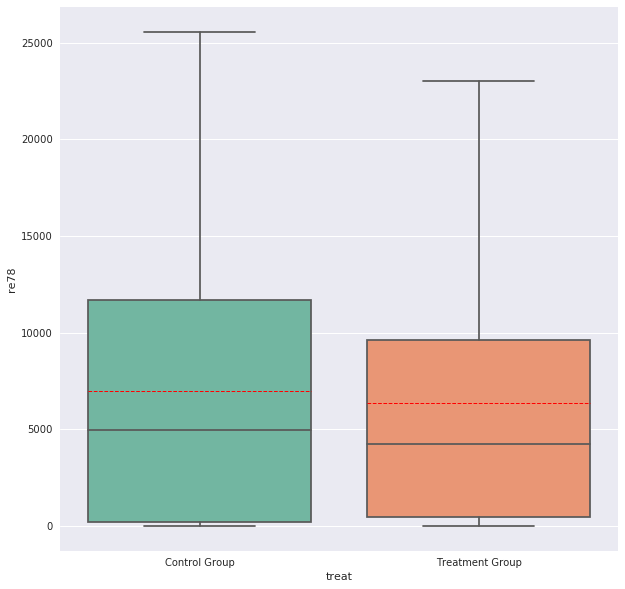

In [5]:
compare_groups(lalonde_data)

In [6]:
lalonde_means = lalonde_data.groupby("treat").agg(np.mean)
print("Control group real earnings in 1978 mean: {:.0f}".format(lalonde_means["re78"].loc[0]))
print("Treatment group real earnings in 1978 mean: {:.0f}".format(lalonde_means["re78"].loc[1]))

Control group real earnings in 1978 mean: 6984
Treatment group real earnings in 1978 mean: 6349


A naive analysis would claim that there are no clear differences between the two groups and thus would conclude that the "Job Training Program" (JTP) is useless. And if a difference exists, people in the treatment groups have a smaller revenue.

## 1.2) A closer look at the data

In [7]:
#Features of each group
main_variables = ['black', 'hispan', 'age', 'married', 'nodegree', 'educ']

#Function that displays a bar plot of each group for every features
def display_proportions(data, variables=main_variables, n_cols=3):
    N = len(variables)
    f, axes = plt.subplots(nrows=int(np.ceil(N / n_cols)), ncols=n_cols)
    f.set_figheight(10)
    for idx, axis, var in zip(range(N), axes.flatten(), variables):
        sns.barplot(x='treat', y=var, data=data, ax=axis)
        axis.set_xticklabels(["Control Group", "Treatment Group"])
        axis.set_xlabel("")
        axis.set_title(idx+1)
        axis.set_ylabel("mean of {}".format(var))

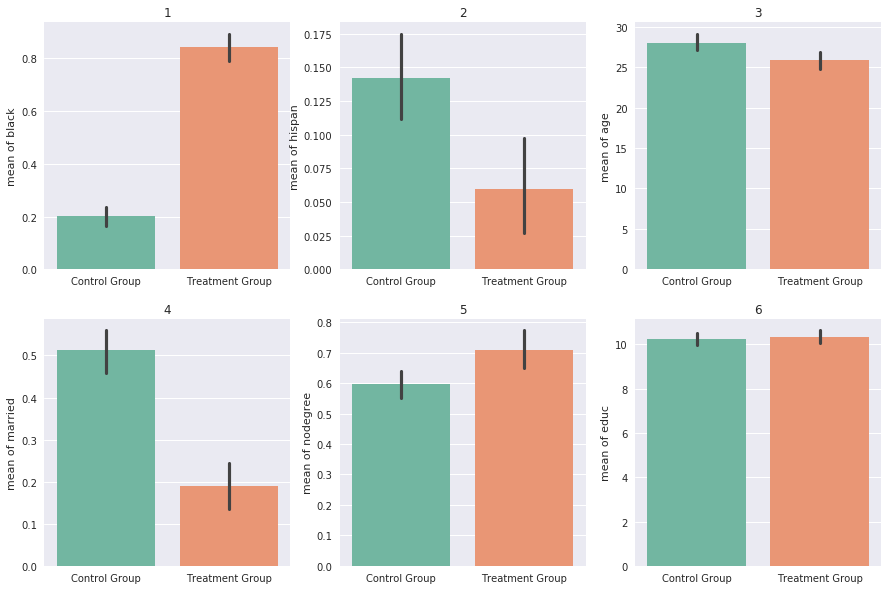

In [8]:
display_proportions(lalonde_data)

#### Obervations

**1**: As we can see on the barplot above, the concentration of black people in the treatment group is 4 times as high as in the control group

**2**: The concentration of hispanic people in the control group is more than twice as high as in the treatment group

**3**: Treatment group is on average 2 years younger that control group

**4**: People in the control group are more than twice as likely to be married than the ones in the treatment group

**5**: The proportion of people without a degree in the treatment group is higher by 20% than in the control group

**6**: The mean and the variance of the of years of education is more or less the same in both groups

With these 6 observations, we can say that that two group are not uniformly separated and that for this reason, it is dangerous to draw a conclusion from a superficial analysis.

Let's also see whether each group has a similar number of sample:

In [9]:
lalond_count = lalonde_data.groupby("treat").agg("count")
print("Number of people in the control group: {}".format(lalond_count["re78"].loc[0]))
print("Number of people in the treatment group: {}".format(lalond_count["re78"].loc[1]))

Number of people in the control group: 429
Number of people in the treatment group: 185


As we can see there is 2.3 times as many sample for the control group. And because of this, we can be picky and select only a part of the samples in the control group that correspond to the samples in the treatement group. To do so, we will match two samples together from each groups corresponding to their propensity score and then only keep and compare the samples matched.

## 1.3) A propensity score model

Let's calculate the propensity score

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr = LogisticRegression()
#Select features, that is drop id and treat columns
selectedFeatures = lalonde_data.drop(['id','treat'], axis=1)
#Fit the model
lr.fit(selectedFeatures, lalonde_data['treat']);

In [12]:
#Calculate the propensity scores
propensity_scores = lr.predict_proba(selectedFeatures)

In [13]:
#Only keep the probability of receiving the treatment and store it inside the dataframe
lalonde_data['propensity score'] = [x[1] for x in propensity_scores]

## 1.4) Balancing the dataset via matching

In [14]:
#One dataframe per group
control_group = lalonde_data[lalonde_data['treat'] == 0]
treatment_group = lalonde_data[lalonde_data['treat'] == 1]

In [15]:
#Compute the distance matrix using the absolute difference of the propensity scores
cost_matrix = spatial.distance.cdist(
    treatment_group["propensity score"].values.reshape((treatment_group.shape[0], 1)),
    control_group["propensity score"].values.reshape((control_group.shape[0], 1)),
    metric=lambda a,b: np.abs(a - b)
)

In [16]:
#Solve the distance matrix to minimze the total cost function. Where the total cost function is the sum of the distances
#And get the indices of the pairs that minimze this total cost function
treatment_ind, control_ind = optimize.linear_sum_assignment(cost_matrix)

In [17]:
#We construct a dataframe whith the rows corresponding to the indices obtaiend above. Note we have the same number of sample in each group by construction
lalonde_ps_matched = pd.concat((treatment_group.iloc[treatment_ind], control_group.iloc[control_ind]))

Now, lets compare the difference in the distribution for each feature in the two groups as done earlier in part 1.2

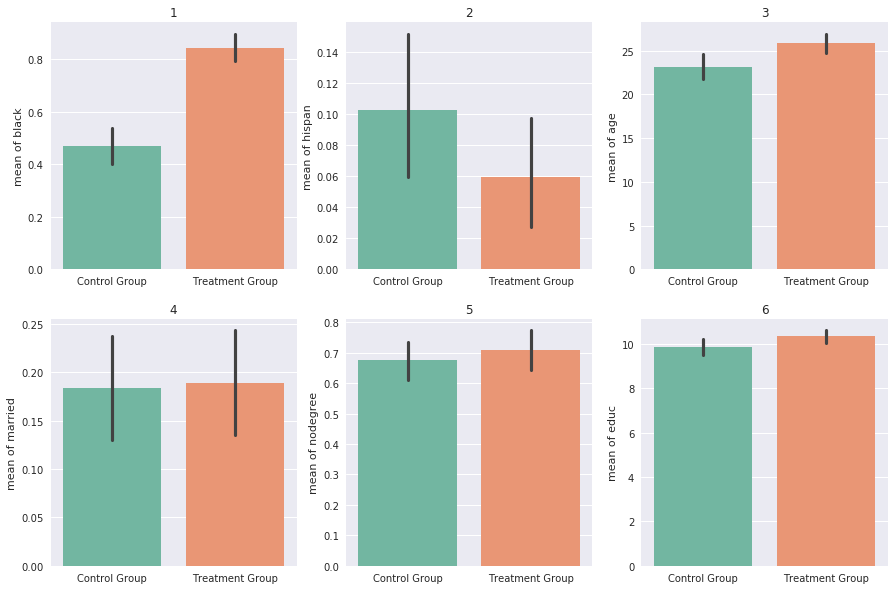

In [18]:
display_proportions(lalonde_ps_matched)

#### Observations

**1**: The difference in the concentration of black people shrinked, however the treatment group's rate is almost still twice the rate of the control group (better than before)

**2**: The concentration of hispanic people in the control group is now twice as high as in the treatment group (better than before)

**3**: The control group is on average 2 years younger than the treatment group (same as before, but reversed)

**4**: People in the control group have now almost the same probability to be married as the ones in the treatment group (better than before)

**5**: The proportion of people without a degree in the treatment group is higher by 5% than in the control group (less than before (20%) )

**6**: The mean and the variance of the of years of education is more or less the same in both groups

Compared to before the matching, the different features are more balanced. The only features that are not roughtly the same are the features that have a racial information in them.

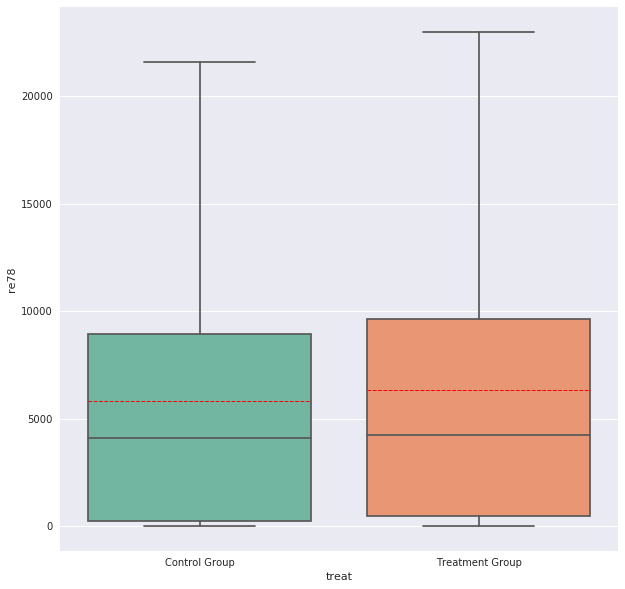

In [19]:
compare_groups(lalonde_ps_matched)

We can now see that the mean in the treatment group is slighter higher thant in the control group, where it was slightly below before. Also the maximum, median and quartiles are all bigger than their counterpart in the control group. This is a complete different information from what we had before, but let's improve it even more.

## 1.5) Balancing the groups further

The main difference in the two groups resides in the proportion of hispanic and black people:

For this reason, we will add the condition when matching two subjects that they have the same value for the hispanic feature. Doing it for the black feature is not possible because 156 people out of the 185 people are black in the treatment group where for the control group there are 87 black people out of the 429 people.

In [20]:
additionnal_feature_matched = 'hispan'

#Compute the distance matrix where a value is 0 if both the row and the colum is hispan, 1 otherwise
add_cost_matrix = spatial.distance.cdist(
    treatment_group[additionnal_feature_matched].values.reshape((treatment_group.shape[0], 1)),
    control_group[additionnal_feature_matched].values.reshape((control_group.shape[0], 1)),
    metric=lambda a,b: int(a != b)
)

In [21]:
#Solve the distance matrix (obtained by adding the propensity score distance matrix to the hispan distance matrix) to minimze the total cost function.
#Where the total cost function is the sum of the distances
#And get the indices of the pairs that minimze this total cost function
treatment_ind_2, control_ind_2 = optimize.linear_sum_assignment(cost_matrix + add_cost_matrix)

## 1.6) A less naive analysis

In [22]:
#We construct a dataframe whith the rows corresponding to the indices obtaiend above. Note we have the same number of sample in each group by construction
lalonde_ps_matched_2 = pd.concat((treatment_group.iloc[treatment_ind_2], control_group.iloc[control_ind_2]))

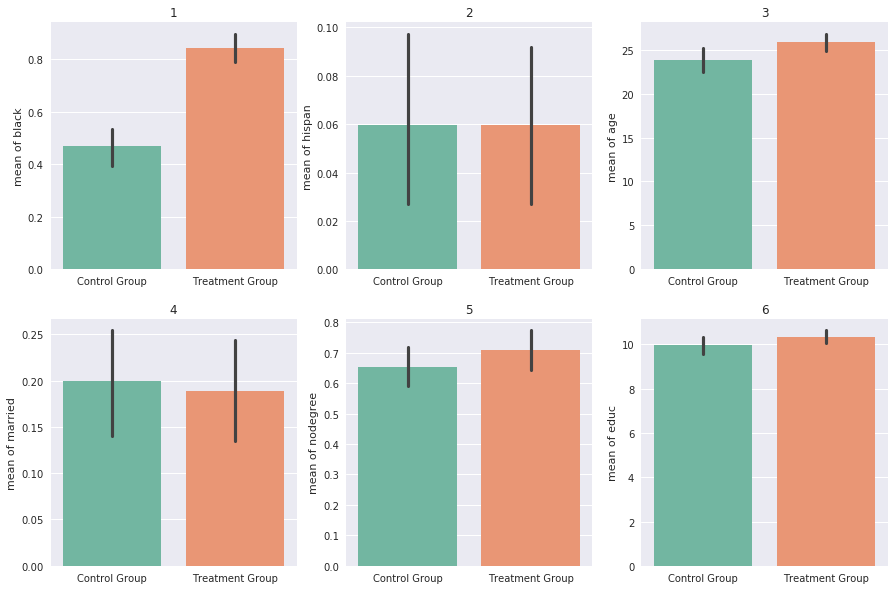

In [23]:
display_proportions(lalonde_ps_matched_2)

### Observations

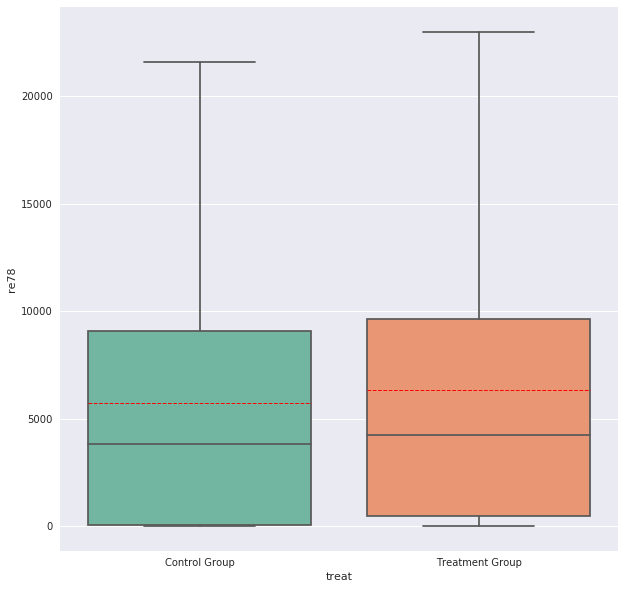

In [24]:
compare_groups(lalonde_ps_matched_2)

# Question 2

In [35]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from time import time

## 2.1) Loading, TF-IDF and Spliting

### Data fetching

In [36]:
#Loading data
all_news = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, sublinear_tf=True)

In [37]:
#Vectorizing
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

### Utility functions

In [38]:
def split(X, y, ratios, acc_X=None, acc_y=None):
    if acc_X == None:
        acc_X = []
    if acc_y == None:
        acc_y = []
    assert np.sum(ratios) < 1
    assert len(ratios) >= 1
    
    ratio, *ratios_remaining = ratios
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio)
    
    if len(ratios_remaining) == 0:
        acc_X.extend([X_train, X_test])
        acc_y.extend([y_train, y_test])
        acc_X.extend(acc_y)
        return tuple(acc_X)
    else:
        acc_X.append(X_train)
        acc_y.append(y_train)
        return split(X_test, y_test, [r/(1.0 - ratio) for r in ratios_remaining], acc_X, acc_y)

In [39]:
def predict(clf, X_train, y_train, X_test):
    start_time = time()
    print("Prediction computations started...")
    clf.fit(X_train, y_train)
    train_time = time() - start_time
    pred = clf.predict(X_test)
    prediction_time = time() - train_time - start_time
    
    print("...Finished")
    print("Training time = {}s".format(round(train_time)))
    print("Prediction time = {}s".format(round(prediction_time // 1)))
    return pred

In [40]:
# Utility function to report best scores given Grid Search CV results

def report(results, n_top=3, compared_to=10):
    means = []
    stds = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean = results['mean_test_score'][candidate]
            std = results['std_test_score'][candidate]
            means.append(mean)
            stds.append(std)
            print("Model with rank: {}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(mean, std))
            print("Parameters: {}".format(results['params'][candidate]))
                        
    min_ = np.min(results['mean_test_score'][results['rank_test_score'] == (compared_to)])
    print('\n{0:}\'th score = {1:.4f}'.format(compared_to, min_))
    means = np.array(means) - min_
    
    plt.title("Top {0} best scores (compared to the {1}'th score = {2:.3f})".format(n_top, compared_to, min_))
    plt.bar(range(n_top), means, yerr=stds, align="center")
    plt.xticks(range(n_top), range(1, n_top + 1))
    plt.xlabel("n'th best scores")
    plt.ylabel("score - {}'th score".format(compared_to))
    plt.show()

### Data splitting

In [41]:
ratios = [0.8, 0.1] #Ratio is 0.8 for train and twice 0.1 for test and validation 

X_train, X_test, X_validation, \
y_train, y_test, y_validation = split(news_data, news_target, ratios)

## 2.2) Random Forest

### Grid search for parameters tuning

In [42]:
# use a full grid over max_depth and n_estimators parameters
param_grid = {
    "max_depth": [3, 10, 20, None],
    "n_estimators": np.linspace(3, 200, num=5, dtype=int)
    #"max_features": [1, 3, 10],
    #"min_samples_split": [2, 3, 10],
    #"min_samples_leaf": [1, 3, 10],
    #"bootstrap": [True, False],
    #"criterion": ["gini", "entropy"]
}

# run grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid_search.fit(X_validation, y_validation)
None #No output cell

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 10, 20, None], 'n_estimators': array([  3,  52, 101, 150, 200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

After having computed an estimation of our model with many different parameters we choose the best parameters (comparing their mean score and std)

Model with rank: 1
Mean validation score: 0.7443 (std: 0.0139)
Parameters: {'max_depth': None, 'n_estimators': 200}
Model with rank: 2
Mean validation score: 0.7273 (std: 0.0141)
Parameters: {'max_depth': None, 'n_estimators': 150}
Model with rank: 3
Mean validation score: 0.7183 (std: 0.0111)
Parameters: {'max_depth': None, 'n_estimators': 101}
Model with rank: 4
Mean validation score: 0.7024 (std: 0.0158)
Parameters: {'max_depth': 20, 'n_estimators': 200}
Model with rank: 5
Mean validation score: 0.7008 (std: 0.0164)
Parameters: {'max_depth': 20, 'n_estimators': 150}

10'th score = 0.6090


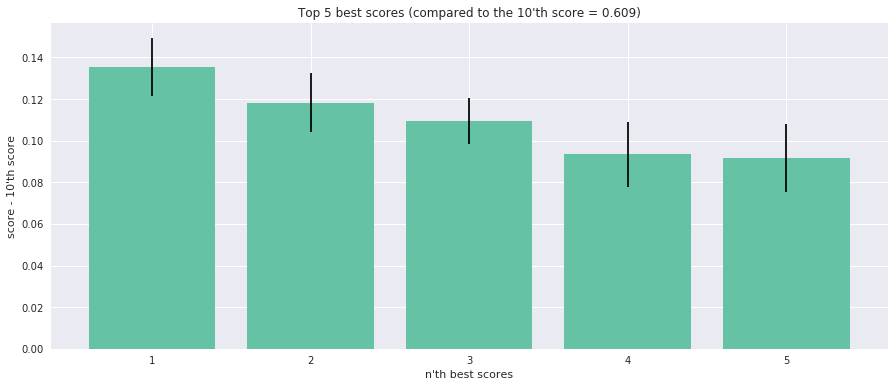

In [44]:
report(grid_search.cv_results_, n_top=5, compared_to=10)

Let's save the parameters which give the best result inside a variable

In [45]:
rank_chosen = 1
best_params = grid_search.cv_results_['params'][np.flatnonzero(grid_search.cv_results_['rank_test_score'] == rank_chosen)[0]]

### Random forest classification

And use these parameters to produce prediction with a random forest classifier

In [46]:
random_forest_clf = RandomForestClassifier(**best_params)

pred = predict(random_forest_clf, X_train, y_train, X_test)

Prediction computations started...
...Finished
Training time = 201s
Prediction time = 0s


In [47]:
#Choose the average type
average_type = "weighted"

#Get the different scores of the predicion computed above
accuracy = metrics.accuracy_score(y_test, pred)
precision = metrics.precision_score(y_test, pred, average=average_type)
recall = metrics.recall_score(y_test, pred, average=average_type)
f1_score = metrics.f1_score(y_test, pred, average=average_type)

print("accuracy  = {:.4f}".format(accuracy))
print("precision = {:.4f}".format(precision))
print("recall    = {:.4f}".format(recall))
print("f1_score  = {:.4f}".format(f1_score))

accuracy  = 0.8658
precision = 0.8700
recall    = 0.8658
f1_score  = 0.8641


As one can see, neither precision, recall or f1_score are adding information. This is because there are quite many classes (20) which are uniformly distributed :

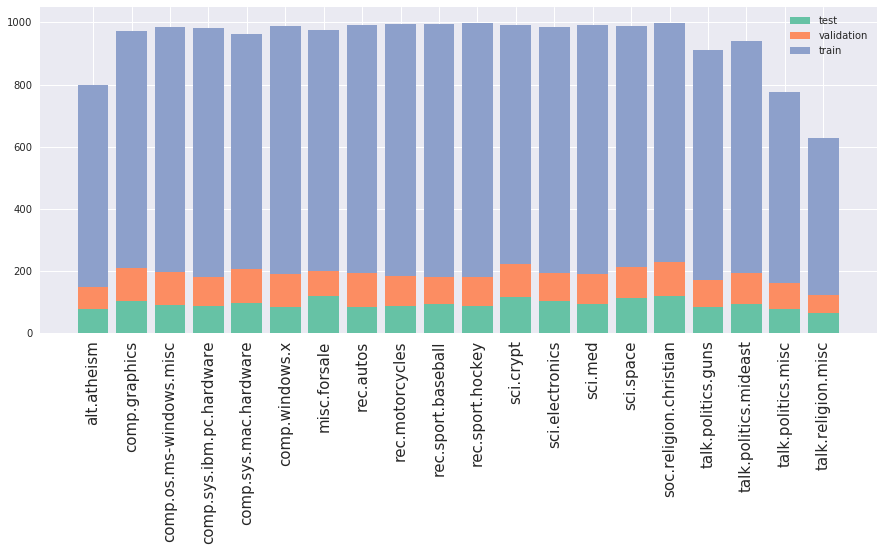

In [48]:
classes = range(len(news_target_names))
def sum_by_class(arr):
    return np.array([np.sum(arr == i) for i in classes])

test_sum_by_class = sum_by_class(y_test)
val_sum_by_class = sum_by_class(y_validation)
train_sum_by_class = sum_by_class(y_train)

p1 = plt.bar(classes, test_sum_by_class)
p2 = plt.bar(classes, val_sum_by_class, bottom=test_sum_by_class)
p3 = plt.bar(classes, train_sum_by_class, bottom=test_sum_by_class + val_sum_by_class)

plt.xticks(classes, news_target_names, rotation='vertical')
plt.tick_params(axis='x', labelsize=15)
plt.legend((p1[0], p2[0], p3[0]), ('test', 'validation', 'train'))

plt.show()

### Confusion matrix

Let's show the confusion matrix

In [83]:
import itertools

# A function to plot the confusion matrix, taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

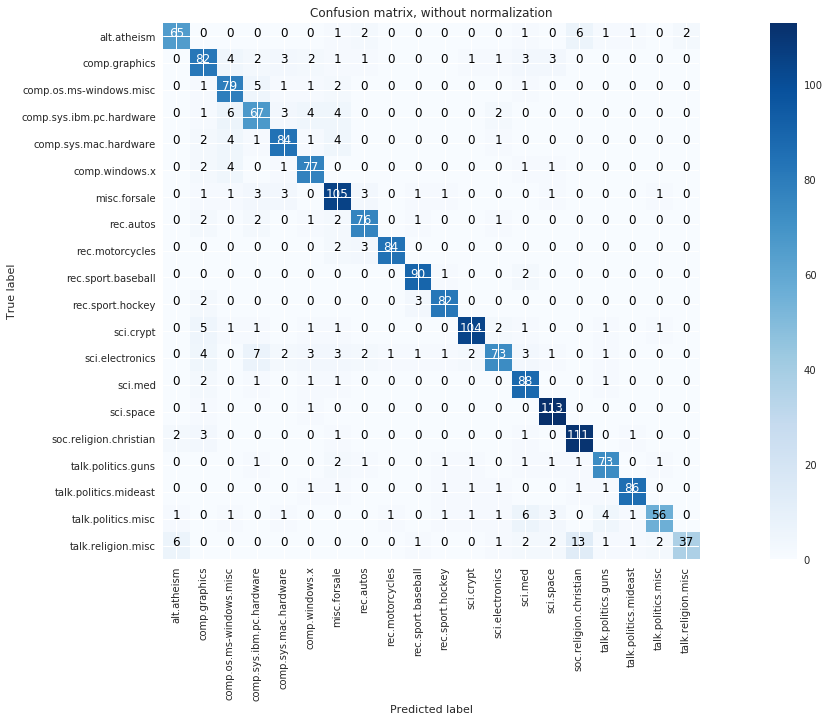

In [85]:
cnf_matrix = metrics.confusion_matrix(y_test, pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(25, 15))
plot_confusion_matrix(cnf_matrix, classes=news_target_names, title='Confusion matrix, without normalization')

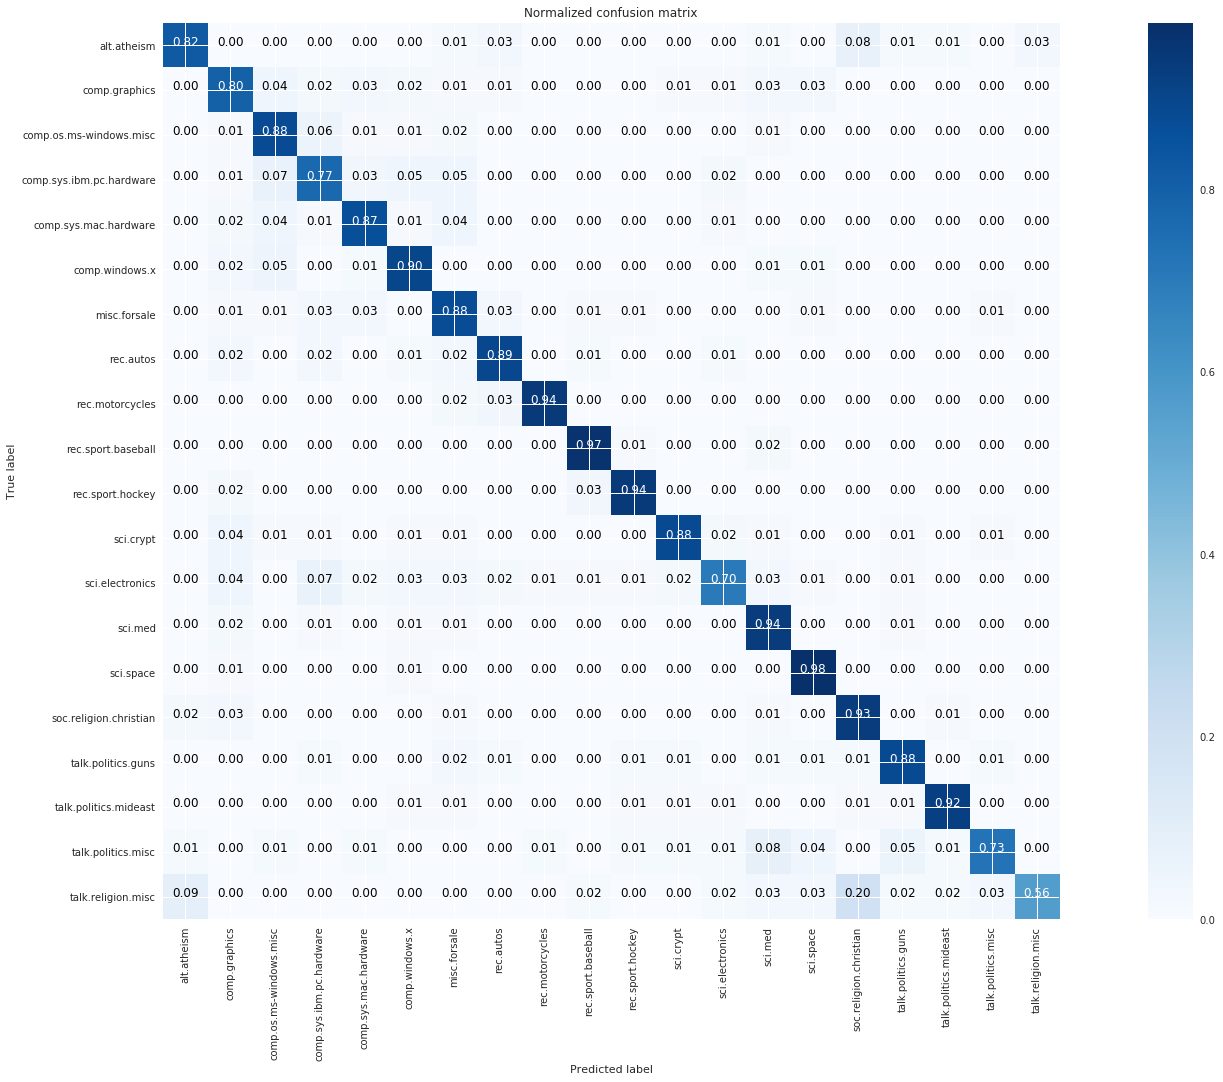

In [87]:
# Plot normalized confusion matrix
plt.figure(figsize=(25, 15))
plot_confusion_matrix(cnf_matrix, classes=news_target_names, normalize=True, title='Normalized confusion matrix')

What the confusion matrices show is that we did a pretty good joob at assignating the categories except we categorized quite a lot of things in religion.christian instead of religion.misc which is understandable because both categories are closely related. Also atheism is closlely related to relgion hence the above average value for ths category but it is still a small value.

Let's see what information the feature\_importances\_ attribute can provide us

### feature\_importances\_ attribute

In [51]:
importances = random_forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_clf.estimators_], axis=0)
#Sort the feature by importance
indices = np.argsort(importances)[::-1]

print("Total number of features = {}".format(len(indices)))

Total number of features = 173446


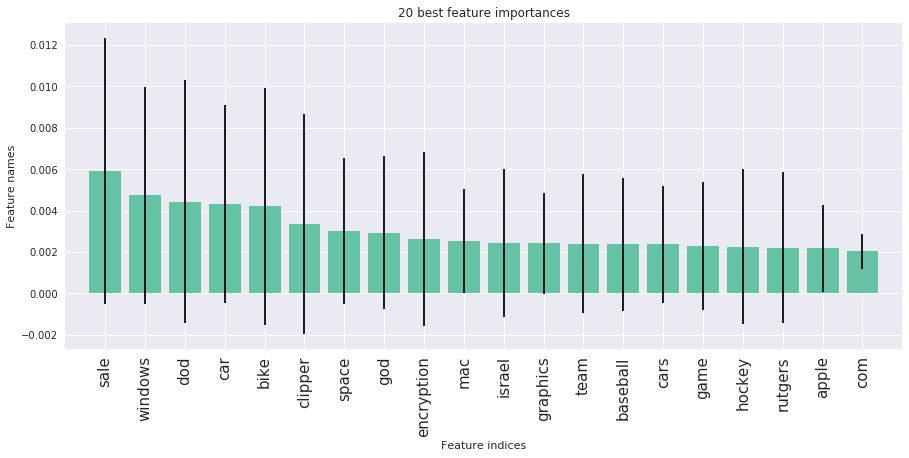

In [52]:
# Only most important ones (out of thousands)
num_best = 20
best_indices = indices[:num_best]
best_importances = importances[best_indices]
best_std = std[best_indices]

# Plot the feature importances
plt.figure()
plt.title("20 best feature importances")
plt.bar(range(num_best), best_importances, yerr=best_std, align="center")
plt.xticks(range(num_best), np.array(feature_names)[best_indices], rotation='vertical')
plt.tick_params(axis='x', labelsize=15)
plt.xlim([-1, num_best])
plt.xlabel("Feature indices")
plt.ylabel("Feature names")
plt.show()

# what to say ?

In [ ]:
1 + 1